#### Import libraries

In [ ]:
%pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
os.environ['PYTHONHASHEEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(123)

python_random.seed(123)

tf.random.set_seed(1234)

In [ ]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from keras.datasets import mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [ ]:
from skopt import forest_minimize, gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

#### Data preparations

In [ ]:
# Carregar o dataset MNIST usando sklearn
mnist = fetch_openml('mnist_784', version=1)

# Obter os dados e os rótulos
X, y = mnist["data"], mnist["target"]

# Converter os rótulos para números inteiros
y = y.astype(int)

# Combinar os dados e os rótulos em um único dataframe
df = pd.DataFrame(X)
df['label'] = y

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
<ipython-input-7-1059718e5a86>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['label'] = y


In [ ]:
df.head(2)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['label'], axis=1),
    df['label'],
    test_size=0.1,
    random_state=42
)

X_train.shape, X_test.shape

((63000, 784), (7000, 784))

Text(0, 0.5, 'Number of images')

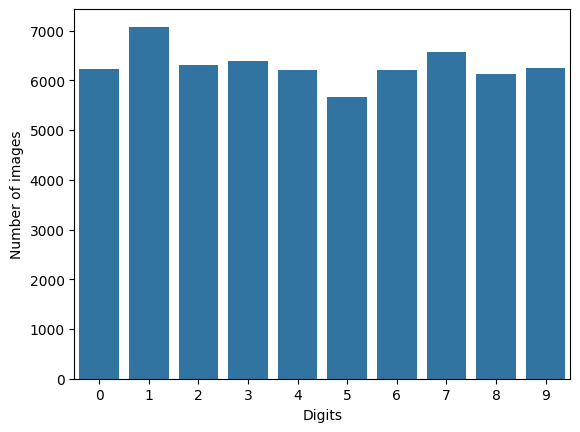

In [ ]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

#### Image re-scaling

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

#### Reshape

In [ ]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

#### Target encoding

In [ ]:
y_train

42878    8
5946     7
33058    6
34692    5
59232    4
        ..
37194    6
6265     6
54886    1
860      0
15795    0
Name: label, Length: 63000, dtype: int64

In [ ]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

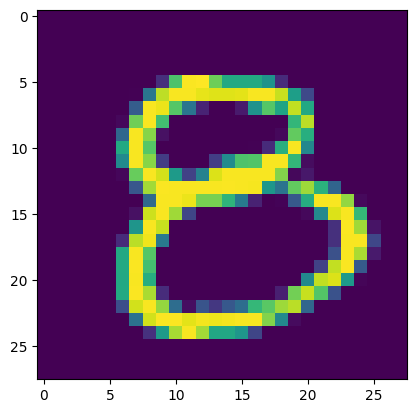

In [ ]:
g = plt.imshow(X_train[0][:,:,0])

#### Define the CNN

In [ ]:
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation
):

  model = Sequential()

  model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                  activation=activation, name='layer_conv1'))
  model.add(MaxPool2D(pool_size=2, strides=2))

  model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                  activation=activation, name='layer_conv2'))
  model.add(MaxPool2D(pool_size=2, strides=2))

  model.add(Flatten())

  for i in range(num_dense_layers):

    model.add(Dense(num_dense_nodes,
                    activation=activation))

  model.add(Dense(10, activation='softmax'))

  optimizer = Adam(lr=learning_rate)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

#### Define the hyperparameter space

In [ ]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')

dim_num_dense_layers = Integer(low=5, high=512, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')

dim_activation = Categorical(categories=['relu', 'sigmoid'], name='activation')

In [ ]:
param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

#### Define the objective function

In [ ]:
path_best_model = 'cnn_model.h5'

best_accuracy = 0

In [ ]:
@use_named_args(param_grid)
def objective(learning_rate, num_dense_layers, num_dense_nodes, activation):

  print('learning rate: {0:.1e}'.format(learning_rate))
  print('num_dense_layers:', num_dense_layers)
  print('num_dense_nodes:', num_dense_nodes )
  print('activation: ', activation)
  print()

  model = create_cnn(learning_rate=learning_rate,
                     num_dense_layers=num_dense_layers,
                     num_dense_nodes=num_dense_nodes,
                     activation=activation)

  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                              patience=2,
                                              verbose=1,
                                              factor=0.5,
                                              min_lr=0.00001)

  history = model.fit(x=X_train,
                      y=y_train,
                      epochs=3,
                      batch_size=128,
                      validation_split=0.1,
                      callbacks=learning_rate_reduction)

  accuracy = history.history['val_accuracy'][-1]

  print()
  print('Accuracy: {0:.2%}'.format(accuracy))
  print()

  global best_accuracy

  if accuracy > best_accuracy:

    model.save(path_best_model)

    best_accuracy = accuracy

  del model

  return -accuracy

#### Test run

In [ ]:
default_parameters = [1e-5, 1, 16, 'relu']
objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation:  relu

Epoch 1/3
443/443 [==============================] - 61s 136ms/step - loss: 0.3491 - accuracy: 0.8932 - val_loss: 0.1139 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 61s 138ms/step - loss: 0.0881 - accuracy: 0.9733 - val_loss: 0.0729 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 60s 135ms/step - loss: 0.0615 - accuracy: 0.9811 - val_loss: 0.0540 - val_accuracy: 0.9827 - lr: 0.0010

Accuracy: 98.27%



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


-0.9826984405517578

In [ ]:

def objective(params):
  learning_rate, num_dense_layers, num_dense_nodes, activation = params


  print('learning rate: {0:.1e}'.format(learning_rate))
  print('num_dense_layers:', num_dense_layers)
  print('num_dense_nodes:', num_dense_nodes )
  print('activation: ', activation)
  print()

  model = create_cnn(learning_rate=learning_rate,
                     num_dense_layers=num_dense_layers,
                     num_dense_nodes=num_dense_nodes,
                     activation=activation)

  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                              patience=2,
                                              verbose=1,
                                              factor=0.5,
                                              min_lr=0.00001)

  history = model.fit(x=X_train,
                      y=y_train,
                      epochs=3,
                      batch_size=128,
                      validation_split=0.1,
                      callbacks=learning_rate_reduction)

  accuracy = history.history['val_accuracy'][-1]

  print()
  print('Accuracy: {0:.2%}'.format(accuracy))
  print()

  global best_accuracy

  if accuracy > best_accuracy:

    model.save(path_best_model)

    best_accuracy = accuracy

  del model

  return -accuracy

#### Bayesian Optimization

In [ ]:
# gp_ = gp_minimize(
#     objective,
#     param_grid,
#     x0=default_parameters,
#     acq_func='EI',
#     n_calls=30,
#     random_state=42
# )


gp_ = gp_minimize(
    objective,
    [
        (1e-5, 1e-3),
        (1, 3),
        (16, 128),
        ('relu', 'tanh')
    ],
    x0=default_parameters,
    acq_func='EI',
    n_calls=30,
    random_state=42
)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation:  relu

Epoch 1/3
443/443 [==============================] - 62s 137ms/step - loss: 0.3136 - accuracy: 0.9032 - val_loss: 0.0917 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 60s 135ms/step - loss: 0.0746 - accuracy: 0.9781 - val_loss: 0.0592 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 61s 137ms/step - loss: 0.0527 - accuracy: 0.9841 - val_loss: 0.0470 - val_accuracy: 0.9843 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Accuracy: 98.43%

learning rate: 8.0e-04
num_dense_layers: 1
num_dense_nodes: 103
activation:  tanh

Epoch 1/3
443/443 [==============================] - 68s 150ms/step - loss: 0.1975 - accuracy: 0.9437 - val_loss: 0.0673 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 63s 141ms/step - loss: 0.0556 - accuracy: 0.9832 - val_loss: 0.0493 - val_accuracy: 0.9841 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 64s 144ms/step - loss: 0.0378 - accuracy: 0.9888 - val_loss: 0.0424 - val_accuracy: 0.9867 - lr: 0.0010



Accuracy: 98.67%

learning rate: 4.5e-04
num_dense_layers: 1
num_dense_nodes: 67
activation:  relu

Epoch 1/3
443/443 [==============================] - 63s 138ms/step - loss: 0.2523 - accuracy: 0.9243 - val_loss: 0.0692 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 60s 136ms/step - loss: 0.0636 - accuracy: 0.9803 - val_loss: 0.0494 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 63s 142ms/step - loss: 0.0444 - accuracy: 0.9867 - val_loss: 0.0437 - val_accuracy: 0.9868 - lr: 0.0010



Accuracy: 98.68%

learning rate: 1.5e-04
num_dense_layers: 2
num_dense_nodes: 22
activation:  tanh

Epoch 1/3
443/443 [==============================] - 64s 142ms/step - loss: 0.3739 - accuracy: 0.9215 - val_loss: 0.1049 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 61s 138ms/step - loss: 0.0847 - accuracy: 0.9782 - val_loss: 0.0758 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 61s 138ms/step - loss: 0.0589 - accuracy: 0.9841 - val_loss: 0.0624 - val_accuracy: 0.9816 - lr: 0.0010



Accuracy: 98.16%

learning rate: 9.4e-04
num_dense_layers: 1
num_dense_nodes: 127
activation:  tanh

Epoch 1/3
443/443 [==============================] - 66s 146ms/step - loss: 0.1790 - accuracy: 0.9492 - val_loss: 0.0628 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 64s 144ms/step - loss: 0.0493 - accuracy: 0.9857 - val_loss: 0.0470 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 63s 142ms/step - loss: 0.0332 - accuracy: 0.9908 - val_loss: 0.0420 - val_accuracy: 0.9886 - lr: 0.0010



Accuracy: 98.86%

learning rate: 6.2e-04
num_dense_layers: 1
num_dense_nodes: 19
activation:  tanh

Epoch 1/3
443/443 [==============================] - 64s 141ms/step - loss: 0.3263 - accuracy: 0.9254 - val_loss: 0.1067 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 62s 140ms/step - loss: 0.0818 - accuracy: 0.9798 - val_loss: 0.0663 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 62s 140ms/step - loss: 0.0558 - accuracy: 0.9852 - val_loss: 0.0604 - val_accuracy: 0.9819 - lr: 0.0010



Accuracy: 98.19%

learning rate: 4.1e-04
num_dense_layers: 1
num_dense_nodes: 125
activation:  relu

Epoch 1/3
443/443 [==============================] - 62s 137ms/step - loss: 0.2179 - accuracy: 0.9360 - val_loss: 0.0666 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 62s 139ms/step - loss: 0.0599 - accuracy: 0.9817 - val_loss: 0.0452 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 61s 137ms/step - loss: 0.0419 - accuracy: 0.9869 - val_loss: 0.0421 - val_accuracy: 0.9873 - lr: 0.0010



Accuracy: 98.73%

learning rate: 1.0e-04
num_dense_layers: 2
num_dense_nodes: 59
activation:  tanh

Epoch 1/3
443/443 [==============================] - 63s 138ms/step - loss: 0.2133 - accuracy: 0.9435 - val_loss: 0.0724 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 61s 138ms/step - loss: 0.0545 - accuracy: 0.9836 - val_loss: 0.0463 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 62s 139ms/step - loss: 0.0380 - accuracy: 0.9887 - val_loss: 0.0496 - val_accuracy: 0.9832 - lr: 0.0010



Accuracy: 98.32%

learning rate: 4.7e-04
num_dense_layers: 3
num_dense_nodes: 92
activation:  relu

Epoch 1/3
443/443 [==============================] - 66s 147ms/step - loss: 0.2587 - accuracy: 0.9176 - val_loss: 0.0810 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 61s 138ms/step - loss: 0.0615 - accuracy: 0.9812 - val_loss: 0.0511 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 62s 141ms/step - loss: 0.0432 - accuracy: 0.9867 - val_loss: 0.0501 - val_accuracy: 0.9832 - lr: 0.0010



Accuracy: 98.32%

learning rate: 2.3e-05
num_dense_layers: 3
num_dense_nodes: 79
activation:  relu

Epoch 1/3
443/443 [==============================] - 63s 139ms/step - loss: 0.2703 - accuracy: 0.9164 - val_loss: 0.0773 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 61s 137ms/step - loss: 0.0634 - accuracy: 0.9808 - val_loss: 0.0457 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 60s 136ms/step - loss: 0.0441 - accuracy: 0.9866 - val_loss: 0.0463 - val_accuracy: 0.9848 - lr: 0.0010



Accuracy: 98.48%

learning rate: 2.6e-05
num_dense_layers: 1
num_dense_nodes: 43
activation:  tanh

Epoch 1/3
443/443 [==============================] - 67s 146ms/step - loss: 0.2420 - accuracy: 0.9354 - val_loss: 0.0741 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 62s 139ms/step - loss: 0.0613 - accuracy: 0.9827 - val_loss: 0.0490 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 62s 140ms/step - loss: 0.0423 - accuracy: 0.9884 - val_loss: 0.0503 - val_accuracy: 0.9846 - lr: 0.0010

Accuracy: 98.46%



learning rate: 7.9e-04
num_dense_layers: 3
num_dense_nodes: 128
activation:  tanh

Epoch 1/3
443/443 [==============================] - 65s 143ms/step - loss: 0.1757 - accuracy: 0.9495 - val_loss: 0.0652 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 64s 145ms/step - loss: 0.0499 - accuracy: 0.9854 - val_loss: 0.0552 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 64s 144ms/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 0.0403 - val_accuracy: 0.9865 - lr: 0.0010

Accuracy: 98.65%



learning rate: 8.8e-04
num_dense_layers: 3
num_dense_nodes: 16
activation:  relu

Epoch 1/3
443/443 [==============================] - 61s 135ms/step - loss: 0.4617 - accuracy: 0.8473 - val_loss: 0.1391 - val_accuracy: 0.9616 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 60s 135ms/step - loss: 0.1111 - accuracy: 0.9668 - val_loss: 0.0969 - val_accuracy: 0.9705 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 62s 140ms/step - loss: 0.0758 - accuracy: 0.9780 - val_loss: 0.0659 - val_accuracy: 0.9806 - lr: 0.0010

Accuracy: 98.06%



learning rate: 2.7e-05
num_dense_layers: 3
num_dense_nodes: 128
activation:  relu

Epoch 1/3
443/443 [==============================] - 68s 151ms/step - loss: 0.2328 - accuracy: 0.9283 - val_loss: 0.0723 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 62s 139ms/step - loss: 0.0626 - accuracy: 0.9808 - val_loss: 0.0499 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 62s 140ms/step - loss: 0.0445 - accuracy: 0.9864 - val_loss: 0.0424 - val_accuracy: 0.9865 - lr: 0.0010

Accuracy: 98.65%



learning rate: 3.0e-04
num_dense_layers: 1
num_dense_nodes: 128
activation:  relu

Epoch 1/3
443/443 [==============================] - 62s 138ms/step - loss: 0.2184 - accuracy: 0.9385 - val_loss: 0.0660 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 63s 142ms/step - loss: 0.0602 - accuracy: 0.9809 - val_loss: 0.0495 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 60s 136ms/step - loss: 0.0439 - accuracy: 0.9869 - val_loss: 0.0397 - val_accuracy: 0.9873 - lr: 0.0010

Accuracy: 98.73%



learning rate: 1.2e-05
num_dense_layers: 1
num_dense_nodes: 125
activation:  tanh

Epoch 1/3
443/443 [==============================] - 65s 143ms/step - loss: 0.1847 - accuracy: 0.9476 - val_loss: 0.0549 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 62s 141ms/step - loss: 0.0483 - accuracy: 0.9857 - val_loss: 0.0415 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 66s 148ms/step - loss: 0.0315 - accuracy: 0.9908 - val_loss: 0.0378 - val_accuracy: 0.9875 - lr: 0.0010

Accuracy: 98.75%



learning rate: 2.5e-05
num_dense_layers: 1
num_dense_nodes: 94
activation:  relu

Epoch 1/3
443/443 [==============================] - 62s 137ms/step - loss: 0.2332 - accuracy: 0.9317 - val_loss: 0.0624 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 61s 138ms/step - loss: 0.0610 - accuracy: 0.9816 - val_loss: 0.0499 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 59s 133ms/step - loss: 0.0434 - accuracy: 0.9871 - val_loss: 0.0446 - val_accuracy: 0.9856 - lr: 0.0010

Accuracy: 98.56%



learning rate: 9.8e-04
num_dense_layers: 3
num_dense_nodes: 58
activation:  relu

Epoch 1/3
443/443 [==============================] - 62s 137ms/step - loss: 0.3036 - accuracy: 0.9057 - val_loss: 0.0833 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 62s 139ms/step - loss: 0.0723 - accuracy: 0.9780 - val_loss: 0.0538 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 60s 136ms/step - loss: 0.0522 - accuracy: 0.9843 - val_loss: 0.0487 - val_accuracy: 0.9838 - lr: 0.0010

Accuracy: 98.38%



learning rate: 9.9e-04
num_dense_layers: 1
num_dense_nodes: 39
activation:  relu

Epoch 1/3
443/443 [==============================] - 64s 141ms/step - loss: 0.2601 - accuracy: 0.9262 - val_loss: 0.0786 - val_accuracy: 0.9759 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 60s 135ms/step - loss: 0.0702 - accuracy: 0.9787 - val_loss: 0.0597 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 60s 135ms/step - loss: 0.0512 - accuracy: 0.9845 - val_loss: 0.0471 - val_accuracy: 0.9856 - lr: 0.0010

Accuracy: 98.56%



learning rate: 9.9e-04
num_dense_layers: 1
num_dense_nodes: 74
activation:  tanh

Epoch 1/3
443/443 [==============================] - 65s 143ms/step - loss: 0.2037 - accuracy: 0.9434 - val_loss: 0.0699 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 67s 152ms/step - loss: 0.0553 - accuracy: 0.9838 - val_loss: 0.0504 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 69s 157ms/step - loss: 0.0372 - accuracy: 0.9895 - val_loss: 0.0436 - val_accuracy: 0.9862 - lr: 0.0010

Accuracy: 98.62%



learning rate: 9.5e-04
num_dense_layers: 2
num_dense_nodes: 128
activation:  relu

Epoch 1/3
443/443 [==============================] - 69s 153ms/step - loss: 0.2268 - accuracy: 0.9309 - val_loss: 0.0657 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 69s 155ms/step - loss: 0.0579 - accuracy: 0.9824 - val_loss: 0.0539 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 71s 161ms/step - loss: 0.0422 - accuracy: 0.9876 - val_loss: 0.0415 - val_accuracy: 0.9863 - lr: 0.0010

Accuracy: 98.63%



learning rate: 7.8e-05
num_dense_layers: 3
num_dense_nodes: 100
activation:  tanh

Epoch 1/3
443/443 [==============================] - 70s 156ms/step - loss: 0.1978 - accuracy: 0.9423 - val_loss: 0.0717 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 69s 155ms/step - loss: 0.0565 - accuracy: 0.9822 - val_loss: 0.0620 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 66s 149ms/step - loss: 0.0398 - accuracy: 0.9877 - val_loss: 0.0560 - val_accuracy: 0.9827 - lr: 0.0010

Accuracy: 98.27%



learning rate: 9.9e-04
num_dense_layers: 3
num_dense_nodes: 42
activation:  tanh

Epoch 1/3
443/443 [==============================] - 62s 136ms/step - loss: 0.2541 - accuracy: 0.9349 - val_loss: 0.0803 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 62s 141ms/step - loss: 0.0613 - accuracy: 0.9828 - val_loss: 0.0518 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 61s 137ms/step - loss: 0.0419 - accuracy: 0.9877 - val_loss: 0.0525 - val_accuracy: 0.9846 - lr: 0.0010

Accuracy: 98.46%



learning rate: 9.9e-04
num_dense_layers: 3
num_dense_nodes: 128
activation:  tanh

Epoch 1/3
443/443 [==============================] - 67s 149ms/step - loss: 0.1741 - accuracy: 0.9499 - val_loss: 0.0629 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 62s 140ms/step - loss: 0.0508 - accuracy: 0.9845 - val_loss: 0.0484 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 63s 143ms/step - loss: 0.0342 - accuracy: 0.9896 - val_loss: 0.0444 - val_accuracy: 0.9854 - lr: 0.0010

Accuracy: 98.54%



learning rate: 1.0e-03
num_dense_layers: 1
num_dense_nodes: 128
activation:  tanh

Epoch 1/3
443/443 [==============================] - 64s 141ms/step - loss: 0.1845 - accuracy: 0.9471 - val_loss: 0.0641 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 61s 139ms/step - loss: 0.0522 - accuracy: 0.9842 - val_loss: 0.0469 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 65s 147ms/step - loss: 0.0350 - accuracy: 0.9898 - val_loss: 0.0410 - val_accuracy: 0.9878 - lr: 0.0010

Accuracy: 98.78%



learning rate: 5.2e-05
num_dense_layers: 1
num_dense_nodes: 128
activation:  relu

Epoch 1/3
443/443 [==============================] - 62s 138ms/step - loss: 0.2135 - accuracy: 0.9391 - val_loss: 0.0622 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 62s 139ms/step - loss: 0.0546 - accuracy: 0.9830 - val_loss: 0.0472 - val_accuracy: 0.9841 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 60s 136ms/step - loss: 0.0382 - accuracy: 0.9888 - val_loss: 0.0358 - val_accuracy: 0.9892 - lr: 0.0010

Accuracy: 98.92%



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


learning rate: 5.6e-05
num_dense_layers: 3
num_dense_nodes: 16
activation:  tanh

Epoch 1/3
443/443 [==============================] - 62s 137ms/step - loss: 0.5245 - accuracy: 0.8919 - val_loss: 0.1535 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 62s 139ms/step - loss: 0.1140 - accuracy: 0.9730 - val_loss: 0.0905 - val_accuracy: 0.9759 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 59s 133ms/step - loss: 0.0752 - accuracy: 0.9811 - val_loss: 0.0820 - val_accuracy: 0.9773 - lr: 0.0010

Accuracy: 97.73%



learning rate: 9.9e-04
num_dense_layers: 1
num_dense_nodes: 126
activation:  relu

Epoch 1/3
443/443 [==============================] - 62s 137ms/step - loss: 0.2087 - accuracy: 0.9398 - val_loss: 0.0582 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 58s 132ms/step - loss: 0.0542 - accuracy: 0.9829 - val_loss: 0.0404 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 59s 132ms/step - loss: 0.0371 - accuracy: 0.9883 - val_loss: 0.0390 - val_accuracy: 0.9879 - lr: 0.0010

Accuracy: 98.79%



learning rate: 1.2e-05
num_dense_layers: 1
num_dense_nodes: 128
activation:  tanh

Epoch 1/3
443/443 [==============================] - 62s 137ms/step - loss: 0.1845 - accuracy: 0.9472 - val_loss: 0.0619 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 61s 137ms/step - loss: 0.0520 - accuracy: 0.9840 - val_loss: 0.0468 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 60s 136ms/step - loss: 0.0349 - accuracy: 0.9900 - val_loss: 0.0508 - val_accuracy: 0.9827 - lr: 0.0010

Accuracy: 98.27%



learning rate: 9.4e-04
num_dense_layers: 3
num_dense_nodes: 128
activation:  relu

Epoch 1/3
443/443 [==============================] - 61s 135ms/step - loss: 0.2397 - accuracy: 0.9248 - val_loss: 0.0694 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 2/3
443/443 [==============================] - 60s 135ms/step - loss: 0.0613 - accuracy: 0.9808 - val_loss: 0.0481 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 3/3
443/443 [==============================] - 58s 131ms/step - loss: 0.0421 - accuracy: 0.9874 - val_loss: 0.0423 - val_accuracy: 0.9851 - lr: 0.0010

Accuracy: 98.51%



#### Analyze the results

In [ ]:
"Best score=%.4f"%gp_.fun

'Best score=-0.9892'

In [ ]:
gp_.x

[5.180839810296259e-05, 1, 128, 'relu']

In [ ]:
gp_.space

Space([Real(low=1e-05, high=0.001, prior='uniform', transform='normalize'),
       Integer(low=1, high=3, prior='uniform', transform='normalize'),
       Integer(low=16, high=128, prior='uniform', transform='normalize'),
       Categorical(categories=('relu', 'tanh'), prior=None)])

In [ ]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation=%s""" % (gp_.x[0],
                      gp_.x[1],
                      gp_.x[2],
                      gp_.x[3]))

Best parameters:
- learning rate=0.000052
- num_dense_layers=1
- num_nodes=128
- activation=relu


#### Convergence

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

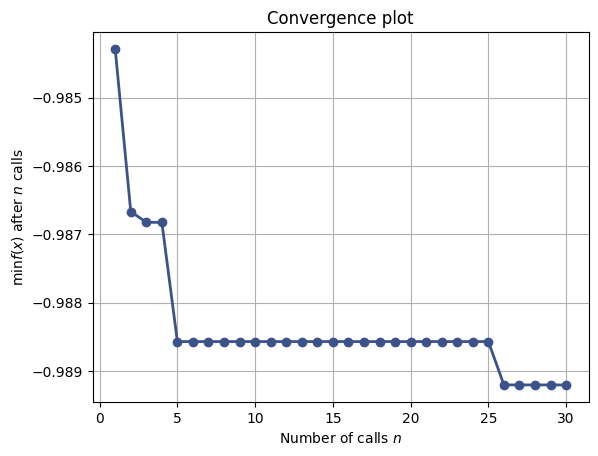

In [ ]:
plot_convergence(gp_)

#### Partially dependency plots

In [ ]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

In [1]:
plot_objective(result=gp_, plot_dims=dim_names)
plt.show()

#### Evaluate order

In [ ]:
plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()

#### Evaluate the model

In [ ]:
model = load_model(path_best_model)

In [ ]:
result = model.evaluate(x=X_test,
                        y=y_test)

In [ ]:
for name, value in zip(model.metrics_names, result):
  print(name, value)

#### Confusion matrix

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

cm

In [ ]:
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(ticks_marks, range(classes), rotation=45)
plt.yticks(ticks_marks, range(classes))

for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j,i, cm[i,j],
           horizontalalignment='center',
           color='white' if cm[i,j] > 100 else 'black',)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')